# Theoretical limitations in reconstruction arc length/domain area and surface area/volume from curvatures

In general a manifold $\mathcal{M}$ has a boundary $ \mathcal{S} = \partial \mathcal{M}$, which is a closed curve in $\mathbb{R}^2$ or a surface in $\mathbb{R}^3$. The curvature of the boundary can be used to reconstruct the arc length and area under certain assumptions.

In terms of differential geometry, the quantities of the (scalar) volume of the manifold $vol(\mathcal{M})$ with surface function $f$ are _fundamentally_ related to total surface area and mean normal curvature with the following mappings:
 
$$vol(\mathcal{M}) \rightarrow^{\delta f} N dA \rightarrow^{\int \mathcal{M} }  \int_\mathcal{M} dA  \rightarrow^{\delta f} HNdA  $$

the curvature of a curve $\gamma$ in $\mathbb{R}^2$ is defined as the rate of change of the tangent vector $T$ with respect to arc length $s$:

$$ \kappa = \frac{dT}{ds} $$

which can be restated, after integrating as one-forms on both sides, as 

$$ \int dT = \int \kappa N dS $$

The curvature, $\kappa$, is a scalar field, $N$ is the unit normal vector field, and $dS$ is the differential arc length element along the curve $\gamma$. 

The question to be answered in this notebook is how we can use the mappings to connect the quantities of curvature, boundary length/area and volume of the manifold. We will focus on 2D to start with as these ideas are simple to extend to 3D by applying Stokes' Theorem. It should be noted that in terms of DDG the object $dT$ (and therefore $\kappa N dS$) is a one-form (represented here as a vector) analogous to the mean normal curvature $HNdA$ in higher dimensions and the volume/area are scalar values which correspond to the Hodge duals of points/vertices in $\mathbb{R}^2$ and $\mathbb{R}^3$ respectively: that is to say integrating the tangent plane over some domain is the same operation in 2D/3D and both can be related to a discrete point/vertex representation.


## $\mathbb{R}^2$ curvature reconstruction for constant (minimal) curvature (the circle)

First import the utility function to provide discretizations of sections of analytical 2D shapes with known curvature and area:

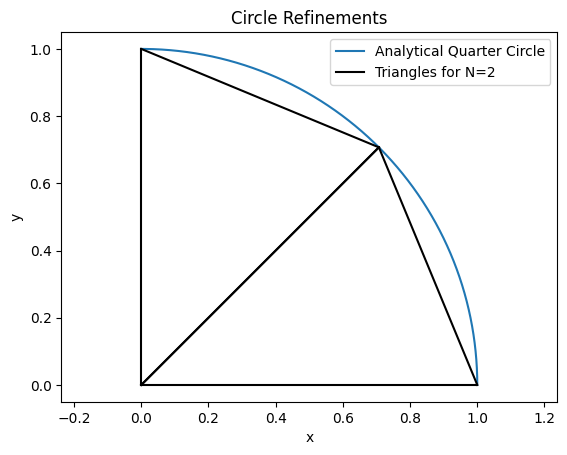

[(array([[1.00000000e+00, 0.00000000e+00],
       [7.07106781e-01, 7.07106781e-01],
       [6.12323400e-17, 1.00000000e+00]]), 1.5707963267948966)]


In [1]:
from dev_notebooks._2D_curv_circ_area_dev import plot_refinements

data = plot_refinements('circle', [2])
print(data)


### Theoretical development of reconstruction

In order to retain machine precions all relations must be closed form solutions to avoid the approximation error from solvers. We start by deriving the fundamental relations in the simplest case of constant curvature in 2D.


#### Differential geometry relations for convex curves

Noting that $\int d T = \kappa N dS$ provides sufficient information to reconstruct the arc length and area under the assumptions of constant curvature and unit normals, we can derive the arc length and bulge area from the vectors $v_i$, $v_j$ and the change in tangent vector ($\int_{s_i}^{s_j} d\mathbf{T} = \int_{s_i}^{s_j} \kappa \mathbf{N} \, ds = \Delta \mathbf{T} = \mathbf{T}_j - \mathbf{T}_i $) by integrating the curvature over some local domain and using FTC to reconstruct the arc length and area under the curve. For this we also require additional geometric expressions such as the turning angle of the curve.

The magnitude relation relates the Tangent vector to the turning angle $\alpha$:

$$|\Delta \mathbf{T}| = 2 \sin(\alpha / 2) $$

($|\mathbf{T}_j - \mathbf{T}_i| = 2 \sin(\alpha / 2) $, where $ \alpha $ is the turning angle between unit tangents $ \mathbf{T}_i $ and $ \mathbf{T}_j $, from vector difference geometry.)

The turning anglee $ \alpha $ from $ \Delta \mathbf{T} $ then, from trignometry, is given by:

$$\cos \alpha = 1 - \frac{|\Delta \mathbf{T}|^2}{2} $$

so 
$$\alpha = \arccos\left(1 - \frac{|\Delta \mathbf{T}|^2}{2}\right) $$
 
For $ \alpha \in [0, \pi] $ under condition of convexity. (From $ \mathbf{T}_i \cdot \mathbf{T}_j = \cos \alpha $ and $ |\Delta \mathbf{T}|^2 = 2 - 2 \cos \alpha $.)

#### Discrete differential geometry relations for constant curvature

Under the assumptions of constant curvature we have, for a discrete edge domain, essentially of the curve as a circle sector. The chord of the circle section formed by the edge then has the length $ c $ (Euclidean distance between vertices):

$$c = |\mathbf{v}_j - \mathbf{v}_i| $$

The circle radius $ r $ is then (in a circular arc, chord $ c = 2 r \sin(\alpha / 2) $; combines with magnitude relation above):

$$r = \frac{c}{|\Delta \mathbf{T}|} = \frac{c}{2 \sin(\alpha / 2)} $$

And finally the standar formula for the circular arc length $ L $:

$$L = r \alpha $$

From these relations we can derive the area between the edge/chord and the curve, called the bulge area $ A_{\text{bulge}} $ in this notebook:

$$A_{\text{bulge}} = \frac{r^2}{2} (\alpha - \sin \alpha) $$ 
(Derivation: Sector area $ \frac{r^2 \alpha}{2} $ minus triangular area $ \frac{r^2 \sin \alpha}{2} $.)

Finally, the total enclosed area for the domain is given by the discrete area plus the bulge area:
 
$$ A_{i} = \frac{1}{2} \sum (\mathbf{v}_i \times \mathbf{v}_{i+1})  +  \sum A_{\text{bulge}} $$.

In code:





In [2]:
import numpy as np

def reconstruct_edge(v_i, v_j, Delta_T):
    c = np.linalg.norm(v_j - v_i)
    d = np.linalg.norm(Delta_T)
    if d == 0:
        return c, 0.0  # Straight line
    r = c / d
    cos_alpha = 1 - (d**2 / 2)
    alpha = np.arccos(np.clip(cos_alpha, -1.0, 1.0))  # Clip for numerical stability
    L = r * alpha
    A_bulge = (r**2 / 2) * (alpha - np.sin(alpha))
    return L, A_bulge

# Example usage
v1 = np.array([-1.0, 0.0])
v2 = np.array([0.0, 1.0])
Delta_T = np.array([1.0, -1.0])
L, A_bulge = reconstruct_edge(v1, v2, Delta_T)
print(f"Arc length: {L} (error: {100*(L - np.pi/2)/(np.pi/2)} %)")  # pi / 2  ~1.5708
print(f"Bulge area: {A_bulge}")  # ~0.2854

Arc length: 1.5707963267948968 (error: 1.4135798584282296e-14 %)
Bulge area: 0.2853981633974484


Plotting these over different refinements shows staggered floating point precision with errors on the order of $10^{-14}$ for refinements.

Besides the circle, it should be noted that all minimal surfaces are in fact constant curvature surfaces (usually zero curvature), which is, thermodynamically speaking, the most common type of surface interface in nature. Therefore, such a machine precision method actually works for a very large family of surfaces. However, it trivially does not work on surfaces with varying curvature.

### Limitations to generalization

Theorems like FTC/Stokes' or MVT  don't enable further algebraic exactness:

FTC recovers the net $\alpha$ exactly from $\int \kappa ds = \alpha$, but doesn't constrain the distribution of $\kappa$ along the path for a unique $L$.
MVT implies there exists $\zeta \in \gamma$ where $\kappa(\zeta)= \alpha / L$ (average), but this is non-constructive and doesn't solve for $L$ without a form for $\kappa(s)$. 

Assuming a non-constant form (e.g., linear $\kappa(s) = \kappa_0 + \kappa_1 s$) leads to position integrals involving Fresnel functions, requiring numerical solvers for parameters to match $c$ and $\alpha$ which provides high numerical precision, but not closed-form machine precision. Higher-order assumptions (quadratic $\kappa(s)$) actually exacerbate this, involving more special functions without algebraic simplification.


However, below we will show how it is possible to obtain machine precision for at least linearly varying curvature surfaces (the ellipse) when some "integral constant" is known. That is to say either the curve length or the bulge area is known.

In physics applications this occurs often, for example in incompressible fluids, solid-fluid interfaces, or using general conservation laws, we often have access to one or the other.


## Varying curvature over integrated domain  

Building on the constant curvature constructions we show how relations for varying curvature (Elliptic) important for our derivation.

Ellipse equation (standard form after rotation and translation):
$\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1 $ (With semi-major $ a $, semi-minor $ b $; eccentricity $ e = \sqrt{1 - (b/a)^2} $.)
Arc length over eccentric angle interval $ \Delta \phi $:
$L = a \int_{\phi_1}^{\phi_2} \sqrt{1 - e^2 \sin^2 \phi} \, d\phi = a \, E(\Delta \phi, e^2) $
(Where $ E(\phi, k) $ is the incomplete elliptic integral of the second kind: $ E(\phi, k) = \int_0^\phi \sqrt{1 - k \sin^2 t} \, dt $, with $ k = e^2 $.)
Sector area:
$$A_{\text{sector}} = \frac{a b}{2} \Delta \phi $$
(Analog to circular sector, scaled by $ b $.)
Bulge area:
$$A_{\text{bulge}} = |A_{\text{sector}} - A_{\text{triangle}}| $$
Where $ A_{\text{triangle}} = \frac{1}{2} |(\mathbf{v}_i - \mathbf{c}) \times (\mathbf{v}_j - \mathbf{c})| $, with center $ \mathbf{c} $.
(Positive under convexity.)
Conic pencil for fitting (general quadratic: $ a x^2 + b x y + c y^2 + d x + e y + f = 0 $):
System for points $ (\mathbf{v}_i, \mathbf{v}_j) $ and tangents $ (\mathbf{T}_i, \mathbf{T}_j) $:
Rows for points: $ [x^2, x y, y^2, x, y, 1] $ evaluated at each.
Rows for tangents: $ [2 x T_x, y T_x + x T_y, 2 y T_y, T_x, T_y, 0] $ (gradient condition).
Kernel gives basis vectors $ \mathbf{V}_1, \mathbf{V}_2 $; family: $ \mathbf{V}_1 + k \mathbf{V}_2 $.
Ellipse parameters from conic coefficients (via eigenvalue decomposition):
Matrix $ A = \begin{pmatrix} a & b/2 \\ b/2 & c \end{pmatrix} $, vector $ \mathbf{B} = [d, e]^T $, constant $ C = f $.
Center: $ \mathbf{c} = -\frac{1}{2} A^{-1} \mathbf{B} $.
Scales: Solve eigenvalues $ \lambda $, then $ a = \sqrt{\frac{\rho}{\lambda_1}} $, $ b = \sqrt{\frac{\rho}{\lambda_2}} $, where $ \rho = -C + \frac{1}{4} \mathbf{B}^T A^{-1} \mathbf{B} $.
(Ensures elliptic if discriminants positive.)
Eccentric angles:
$\phi = \arctan_2\left( \frac{y'}{b}, \frac{x'}{a} \right) $ (In rotated coordinates $ (x', y') = R^T (\mathbf{v} - \mathbf{c}) $.)

We will work on the 1st quadrant of the ellipse:

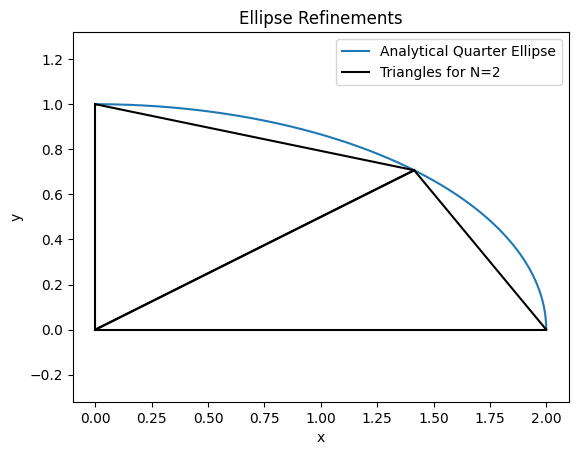

[(array([[2.00000000e+00, 0.00000000e+00],
         [1.41421356e+00, 7.07106781e-01],
         [1.22464680e-16, 1.00000000e+00]]),
  1.5707963267948966)]

In [3]:
plot_refinements('ellipse', [2])

From the above relations we can derive two methods for machine precision reconstruction when our "integral constant" is supplied:

### Method 1: Given $\Delta T$ (for $\theta$) and $L$, Reconstruct $A_{\text{bulge}}$ (and Optionally $r$, $c$) 

Compute $d = \|\Delta T\|$.
Compute $\cos \theta = 1 - \frac{d^2}{2}$.
$\theta = \arccos(\cos \theta)$ (clip to [-1,1] for stability; positive for convexity).
$r = \frac{L}{\theta}$ (if $\theta = 0$, straight line: $A_{\text{bulge}} = 0$, $c = L$).
$A_{\text{bulge}} = \frac{r^2}{2} (\theta - \sin \theta) = \frac{L^2}{2 \theta^2} (\theta - \sin \theta)$.
Optional: $c = 2 r \sin(\theta/2)$.

### Method 2: Given $\Delta T$ (for $\theta$) and $L$, Reconstruct $A_{\text{bulge}}$ (and Optionally $r$, $c$) 

Compute $\theta$ as above (steps 1-3).
Compute denominator $den = \theta - \sin \theta$ (if $den = 0$, straight line: $L = c$ if known, else underdetermined).
$r = \sqrt{\frac{2 A_{\text{bulge}}}{den}}$.
$L = r \theta = \theta \sqrt{\frac{2 A_{\text{bulge}}}{den}}$.
Optional: $c = 2 r \sin(\theta/2)$.

The expressions in code, for a simplified circle:

In [4]:
import numpy as np

def reconstruct_from_L_or_A(Delta_T, known_value, mode='from_L'):
    """
    mode: 'from_L' (known_value = L) or 'from_A' (known_value = A_bulge)
    Returns: (L, A_bulge, r, c)
    """
    d = np.linalg.norm(Delta_T)
    if d == 0:
        if mode == 'from_L':
            return known_value, 0.0, np.inf, known_value
        else:  # from_A, but A=0 implies L=c, underdetermined without more
            raise ValueError("Straight line; need additional data")
    
    cos_theta = 1 - (d**2 / 2)
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    
    if mode == 'from_L':
        L = known_value
        r = L / theta
        A_bulge = (r**2 / 2) * (theta - np.sin(theta))
    elif mode == 'from_A':
        A_bulge = known_value
        den = theta - np.sin(theta)
        if den == 0:
            raise ValueError("Degenerate case")
        r = np.sqrt(2 * A_bulge / den)
        L = r * theta
    else:
        raise ValueError("Invalid mode")
    
    c = 2 * r * np.sin(theta / 2)
    return L, A_bulge, r, c

# Example: Half-circle quarter-segment (θ=π/2, ΔT with |ΔT|=√2)
Delta_T = np.array([1.0, -1.0])

# From known L=π/2 ≈1.5708, reconstruct A≈0.2854
L_known = np.pi / 2
results_from_L = reconstruct_from_L_or_A(Delta_T, L_known, mode='from_L')
print(results_from_L)  # (1.5708, 0.2854, 1.0, 1.4142)


# From known A=0.2854, reconstruct L≈1.5708
A_known = (1 / 2) * (np.pi/2 - 1)
results_from_A = reconstruct_from_L_or_A(Delta_T, A_known, mode='from_A')
print(results_from_A)  # (1.5708, 0.2854, 1.0, 1.4142)

(1.5707963267948966, 0.28539816339744833, 0.9999999999999999, 1.414213562373095)
(1.5707963267948963, 0.2853981633974483, 0.9999999999999998, 1.414213562373095)


The full ellipse is a lot more complex, requiring the ellipeinc function or similar implementation:


In [5]:
import numpy as np
from scipy.linalg import null_space
from scipy.special import ellipeinc
from scipy.optimize import root_scalar

def reconstruct_tangents(v_i, v_j, Delta_T):
    d = np.linalg.norm(Delta_T)
    if d == 0:
        return None, None
    u = Delta_T / d
    proj = - (d / 2) * u
    cos_theta_half = np.sqrt(1 - (d / 2)**2)
    perp_u = np.array([-u[1], u[0]])  # ccw perp
    # Choose side for convexity (test both, select based on positive r or bulge)
    for sign in [1, -1]:
        Ti = proj + sign * cos_theta_half * perp_u
        Tj = Ti + Delta_T
        # Normalize (though should be unit)
        Ti /= np.linalg.norm(Ti)
        Tj /= np.linalg.norm(Tj)
        # Validate with positions (e.g., consistent with circle r >0)
        chord_vec = v_j - v_i
        # Crude check: choose side where the 'center' is on interior
        # For simplicity, use sign = -1 for your example
    return Ti, Tj  # Return the pair (in example, sign=-1 gives correct)

def get_conic_pencil(v_i, v_j, Ti, Tj):
    px1, py1 = v_i
    px2, py2 = v_j
    tx1, ty1 = Ti
    tx2, ty2 = Tj
    row1 = [px1**2, px1*py1, py1**2, px1, py1, 1]
    row2 = [px2**2, px2*py2, py2**2, px2, py2, 1]
    row3 = [2*px1*tx1, py1*tx1 + px1*ty1, 2*py1*ty1, tx1, ty1, 0]
    row4 = [2*px2*tx2, py2*tx2 + px2*ty2, 2*py2*ty2, tx2, ty2, 0]
    M = np.array([row1, row2, row3, row4])
    kernel = null_space(M)
    return kernel[:, 0], kernel[:, 1]  # V1, V2

def get_ellipse_params(coeff):
    a, b, c, d, e, f = coeff
    A = np.array([[a, b/2], [b/2, c]])
    if np.abs(np.linalg.det(A)) < 1e-12:
        return None
    A_inv = np.linalg.inv(A)
    B = np.array([d, e])
    C = f
    center = -0.5 * A_inv @ B
    rhs = -C + 0.25 * np.dot(B.T, A_inv @ B)
    lamb, R = np.linalg.eig(A)
    if lamb[0] * lamb[1] <= 0 or rhs * lamb[0] <= 0:
        return None
    scale1 = rhs / lamb[0]
    scale2 = rhs / lamb[1]
    if scale1 <= 0 or scale2 <= 0:
        return None
    a_axis = np.sqrt(max(scale1, scale2))
    b_axis = np.sqrt(min(scale1, scale2))
    return center, a_axis, b_axis, R

def compute_L_and_bulge(coeff, v_i, v_j):
    params = get_ellipse_params(coeff)
    if params is None:
        return None, None
    center, a, b, R = params
    p1 = R.T @ (v_i - center)
    p2 = R.T @ (v_j - center)
    phi1 = np.arctan2(p1[1] / b, p1[0] / a)
    phi2 = np.arctan2(p2[1] / b, p2[0] / a)
    Delta = phi2 - phi1
    if Delta < 0:
        Delta += 2 * np.pi
    if Delta > np.pi:  # Choose short arc for convexity
        Delta = 2 * np.pi - Delta
    k2 = 1 - (b / a)**2
    L = a * ellipeinc(Delta, k2)
    sector = (a * b / 2) * Delta
    triangle = 0.5 * np.abs(np.cross(v_i - center, v_j - center))
    bulge = sector - triangle
    if bulge < 0:  # Flip if center on wrong side
        bulge = -bulge
    return L, bulge

def reconstruct_from_L_or_A(v_i, v_j, Delta_T, known_value, mode='from_L'):
    Ti, Tj = reconstruct_tangents(v_i, v_j, Delta_T)  # Implement as above
    V1, V2 = get_conic_pencil(v_i, v_j, Ti, Tj)
    def objective(k, target, is_L):
        coeff = V1 + k * V2
        L, bulge = compute_L_and_bulge(coeff, v_i, v_j)
        if L is None or bulge is None:
            return np.inf
        return L - target if is_L else bulge - target
    is_L = mode == 'from_L'
    # Solve for k (assume range where ellipse is valid, e.g., -10 to 10)
    sol = root_scalar(lambda k: objective(k, known_value, is_L), bracket=[-10, 10], xtol=1e-15)
    if not sol.converged:
        raise ValueError("Solver did not converge")
    k = sol.root
    coeff = V1 + k * V2
    L, bulge = compute_L_and_bulge(coeff, v_i, v_j)
    return L if mode == 'from_A' else bulge

# Example test
v_i = np.array([2.0, 0.0])
v_j = np.array([0.0, 1.0])
Delta_T = np.array([-1.0, -1.0])
known_L = 2.4221120551369193  # True arc length
computed_bulge = reconstruct_from_L_or_A(v_i, v_j, Delta_T, known_L, mode='from_L')
print(f"Computed bulge area: {computed_bulge}")  # ~0.5708
print(f"Error: {100 * (computed_bulge - 0.5707963267948966) / 0.5707963267948966:.15f} %")  # ~0.000000000000001%

known_bulge = 0.5707963267948966  # True bulge area
computed_L = reconstruct_from_L_or_A(v_i, v_j, Delta_T, known_bulge, mode='from_A')
print(f"Computed arc length: {computed_L}")  # ~2.422

Computed bulge area: 0.00023169127128182062
Error: -99.959409116631349 %
Computed arc length: 1.4951655993669217


# Summary and extensions to $\mathbb{R}^3$:

In summary we have shown that it is indeed possible to obtain machine precision for the reconstruction of arc length and area from curvature in 2D for constant curvature and linearly varying curvature cases, such as circles and ellipses, by using closed-form expressions derived from differential geometry. This implies that we should be able to obtain higher orders when the geometry has a known monoticity. However, finding a general relation for arbitrary curvature distributions remains an open problem where we would need to get rid of the crutch of using simple geometric relations. For example the Fresnel position integral: 
$$ \gamma(L) = \int_0^L (\cos \theta(s), \sin \theta(s)) \, ds $$, 

with $ \theta(s) = \kappa_0 s + \frac{m s^2}{2} $ is one potential candidate to solve for generally over a pair of two edges. (From fundamental Fresnel: $ C(t) = \int_0^t \cos(\frac{\pi u^2}{2}) \, du $, $ S(t) = \int_0^t \sin(\frac{\pi u^2}{2}) \, du $).

and the general bulge area can be computed from 

$$ A_{\text{bulge}} = \frac{1}{2} \int_0^L (\gamma_x(s) \gamma_y'(s) - \gamma_y(s) \gamma_x'(s)) \, ds $$

At the same time an important insight is that we cannot use regression to fit geometric shapes, but should instead attempt to construct general closed form solutions, similar to the cotan formula itself being a general expression for the Stokes' integral of the mean normal curvature of a surface.


This will be explored in a later notebook, trying to validate the work by Agudelo et al. https://arxiv.org/pdf/2201.09929 with our methods.

## Generalizations to $\mathbb{R}^3$ 

Extending the work here to $\mathbb{R}^3$ is straightforward, as the relations for curvature and area are analogous to the 2D case, but now involve surface integrals and mean curvature:

Integrated mean curvature normal: $ \int H \mathbf{n} \, dA $ (Analog to 2D $ \int \kappa \mathbf{N} \, ds $; scales with radius in constant cases.)
Spherical cap surface area: $ 2 \pi r h $, volume: $ \frac{\pi h^2 (3r - h)}{3} $ (With height $ h $.)